### Alpaca/Quandl API

In [56]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
import hvplot.pandas
import alpaca_trade_api as tradeapi
from scipy.optimize import minimize
import ipywidgets as widgets
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [3]:
type(alpaca_secret_key)

str

#### Check Available Tickers from Alpaca Markets API

In [4]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]

In [5]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head())

symbol
0    HBT
1   FLHK
2  HCACU
3   HCAP
4    HCC

In [6]:
# inputs from users
answer = 'N'
while answer == 'N':
# number of stocks
    n = int(input("Enter number of tickers : ")) 
  
    # Below line read inputs from user using map() function  
    tickers = list(map(str,input("\nEnter the ticker names separated by a blank space: ").strip().split()))[:n] 
  
    print("\nList of tickers is - ", tickers)
    answer = str(input('Is this list is not correct type "N"')) 

Enter number of tickers :  3

Enter the ticker names separated by a blank space:  JPM AAPL TSLA



List of tickers is -  ['JPM', 'AAPL', 'TSLA']


Is this list is not correct type "N" d


In [7]:
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index df
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head(10)

AAPL       JPM      TSLA
                              close     close     close
time                                                   
2019-01-02 00:00:00-05:00  157.5225   99.1999  309.8699
2019-01-03 00:00:00-05:00  142.2900   97.3200  300.3100
2019-01-04 00:00:00-05:00  148.1200  100.6600  317.5400
2019-01-07 00:00:00-05:00  147.9100  100.8600  334.9860
2019-01-08 00:00:00-05:00  150.6300  100.4900  335.4900
2019-01-09 00:00:00-05:00  153.3700  100.2800  338.5200
2019-01-10 00:00:00-05:00  153.5500  100.3800  344.9100
2019-01-11 00:00:00-05:00  152.0534  100.0000  347.3500
2019-01-14 00:00:00-05:00  149.7600  100.9400  334.7000
2019-01-15 00:00:00-05:00  152.9500  101.6100  344.3450

In [8]:
from datetime import datetime
date_format = "%Y-%m-%d"
a = datetime.strptime('2019-01-01', date_format)
b = datetime.strptime('2019-12-31', date_format)

In [9]:
# returns of assets
returns_df = df.pct_change()

In [10]:
# Drop Nulls
returns_df.dropna(inplace = True)

In [11]:
returns_df.head()

AAPL       JPM      TSLA
                              close     close     close
time                                                   
2019-01-03 00:00:00-05:00 -0.096700 -0.018951 -0.030851
2019-01-04 00:00:00-05:00  0.040973  0.034320  0.057374
2019-01-07 00:00:00-05:00 -0.001418  0.001987  0.054941
2019-01-08 00:00:00-05:00  0.018390 -0.003668  0.001505
2019-01-09 00:00:00-05:00  0.018190 -0.002090  0.009032

In [12]:
# the function that we'll optimize is "neg_portfolio_sharpR"
def neg_portfolio_sharpR (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # compute annual s.d.
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (-stocks_returns_annual/stocks_returns_sd_ann)

In [13]:
# checking the function produces sensible results
# with equal weights 
lst = []
for l in range(len(tickers)):
    lst.append(1/len(tickers))
-neg_portfolio_sharpR (lst)

2.3712173607966607

In [14]:
num_assets = len(tickers)
# The constraint is that the sum of weights needs to be equal to 1:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bound = (0.0,1.0) # no negative weights (no short-selling)
bounds = tuple(bound for asset in range(num_assets))
# We use the Sequential Least SQuares Programming (SLSQP) Algorithm
result = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints)

In [15]:
result

     fun: -3.367340088773644
     jac: array([-0.82256532, -0.82266471, -0.44524267])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.73766696, 0.26233304, 0.        ])

In [16]:
# optimal Sharpe ratio is the negative of the minimum
optimal_Sharpe = -result.fun
optimal_Sharpe

3.367340088773644

In [17]:
# setting up weights in a dataframe
def opt_weights_df(results):
    opt_weights_df = pd.DataFrame(result.x).transpose()
    # renaming columns with tickers names
    opt_weights_df = pd.DataFrame (data = opt_weights_df.values, columns = returns_df.columns)
    return opt_weights_df

In [18]:
opt_weights_df(result)

AAPL       JPM  TSLA
      close     close close
0  0.737667  0.262333   0.0

In [19]:
# return and volatility associated with optimal Sharpe Ratio
# we need two functions
def portfolio_return (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    return (stocks_returns_annual)

def portfolio_vol (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # compute annual s.d.
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (stocks_returns_sd_ann)

In [20]:
# optimal portfolio return
portfolio_return (result.x)

0.7421529125500628

In [21]:
# optimal portfolio volatility
portfolio_vol(result.x)

0.22039737388698047

In [22]:
# Code to generate the efficient frontier

np.random.seed(42)
# 3000 times the number of stocks seems a sensible value
num_ports = len(tickers) * 5000
all_weights = np.zeros((num_ports, len(tickers)))
# This array contains the returns (lenght num_ports) 
ret_arr = np.zeros(num_ports)
# This array contains the volatilities (lenght num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    w = np.array(np.random.random(len(tickers)))
    # we need to normalize weights so that these add to 1
    w = w/np.sum(w)
    # Save weights
    all_weights[x,:] = w
    
    # For returns we use the same methodology used
    # for previous sections
    stocks_portfolio_df = returns_df.dot(w)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # array with final returns
    ret_arr[x] = stocks_returns_annual

    # Expected volatility
    vol_arr[x] = stocks_portfolio_df.std()*np.sqrt(252)
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [23]:
# ef Sharpe ratio
ef_Sharpe = sharpe_arr.max()
ef_Sharpe 

3.3664845361991227

In [24]:
# best weights combination from efficient frontier (sub-optimal)
ef_weights_df = pd.DataFrame(all_weights[sharpe_arr.argmax()]).transpose()
# renaming columns with tickers names
ef_weights_df = pd.DataFrame (data = ef_weights_df.values, columns = returns_df.columns)
ef_weights_df

AAPL       JPM      TSLA
     close     close     close
0  0.73747  0.260369  0.002161

In [25]:
# these two variables kept the return and volatility
# of the maximum Sharpe-ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

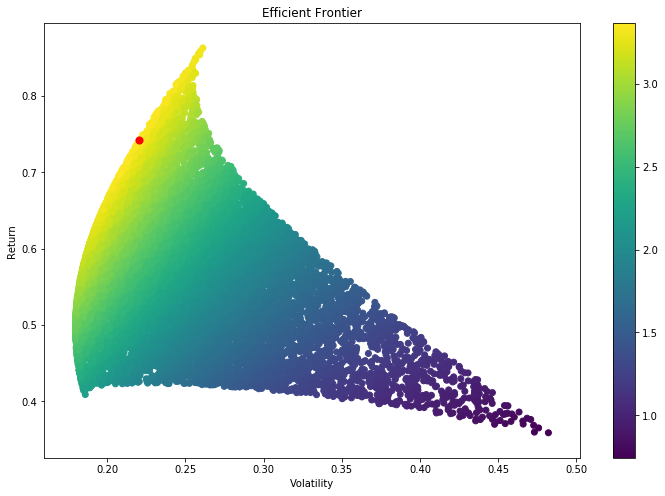

In [26]:
# instructions to plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar()
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# red dot is the point in the frontier with
# the maximum Sharpe-ratio
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

### Finding the optimal return for a specific level of portfolio volatility

The strategy is to use the same objective function used for the optimal Sharpe ratio: neg_portfolio_sharpR. The variation here is to add add another constraint: a specific level of volatility provided directly by the user. The new constraint is a bit convoluted so we'll set up a specific function for that.

In [27]:
# function computes portfolio-vol for a specific set of weights
def portfolio_volatility(weights):
    stocks_portfolio_df = returns_df.dot(weights)
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    return stocks_returns_sd_ann

In [28]:
vol_user = 0.14

In [29]:
# new dictionary for the extra-constraint
constraints_fixed_vol = (
   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
   {'type': 'eq', 'fun': lambda x: vol_user - portfolio_volatility(x)}
                        )

In [30]:
# new optimization function
result_fixed_vol = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints_fixed_vol)
result_fixed_vol

     fun: -2.759395824294038
     jac: array([-2.44787821,  0.04372445, -0.46500957])
 message: 'Positive directional derivative for linesearch'
    nfev: 185
     nit: 25
    njev: 21
  status: 8
 success: False
       x: array([0.19477518, 0.77627772, 0.02894709])

In [31]:
# dataframe with the weights for the user-defined vol level
opt_weights_df(result_fixed_vol)

AAPL       JPM  TSLA
      close     close close
0  0.737667  0.262333   0.0

In [32]:
result.x

array([0.73766696, 0.26233304, 0.        ])

In [33]:
# customerl portfolio return
portfolio_return (result_fixed_vol.x)

0.4956889511274629

In [34]:
# sanity check for portfolio volatility
portfolio_vol(result_fixed_vol.x)

0.17963676931136896

### Adding the portfolio frontier line

In [61]:
# initial vol will be 50% of optimal vol
initial_vol = portfolio_vol(result.x) - portfolio_vol(result.x)*0.5
initial_vol

0.11019868694349023

In [66]:
# granularity will be 0.25% vol
vol_points = portfolio_vol(result.x)/0.0025
vol_points = int(round(vol_points,0))

# we call the minimization routine for each vol_point
ef_lst = []
for n in range(vol_points())


88

___
## Forecasting portfolio returns

In [35]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 1
monte_carlo = pd.DataFrame()

In [36]:
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [58]:
returns_df.mean()

AAPL  close    0.002617
JPM   close    0.001425
TSLA  close    0.001669
dtype: float64

In [37]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):

    # let's set-up data structure
    simulated_PRICES_df = pd.DataFrame()
    # start of simulation is last historical price
    last_prices_df = df[-1:]
    
    # Very first simulation is based on history
    simulated_price_df = last_prices_df * (1 + np.random.normal(returns_df.mean(), returns_df.std()))
    simulated_price_df = simulated_price_df * (1 + np.random.normal(returns_df.mean(), returns_df.std()))
    simulated_PRICES_df = pd.concat([simulated_price_df,simulated_PRICES_df], axis = 'index')
    for i in range(number_records -1):
        
        # Calculate the simulated price using the last price within the list
        simulated_price_df = simulated_price_df * (1 + np.random.normal(returns_df.mean(), returns_df.std()))

                
        # Concatenate new simulated price to existing simulated dataframe
        simulated_PRICES_df = pd.concat([simulated_price_df,simulated_PRICES_df], axis = 'index')
        
    # Append a simulated prices of each simulation to DataFrame
    #simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    #simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_PRICES_df.pct_change()


    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(result.x)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()      

In [53]:
portfolio_cumulative_returns.reset_index(inplace = True)

In [54]:
del portfolio_cumulative_returns['time']

In [57]:
portfolio_cumulative_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)